# Make mock events, and evaluate the resulting strategy

After each run, you MUST restart your kernel

In [1]:
from rubin_scheduler.scheduler.example import example_scheduler
from rubin_scheduler.scheduler.schedulers import core_scheduler
import numpy as np
import healpy as hp
import healsparse
from rubin_scheduler.scheduler.utils import SimTargetooServer, TargetoO
from rubin_scheduler.scheduler.model_observatory import ModelObservatory

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.surveys.too_scripted_surveys import ToOScriptedSurvey

import rubin_scheduler.scheduler.basis_functions as basis_functions
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
import rubin_scheduler
rubin_scheduler.__version__

'3.8.1.dev4+gafe4d83'

In [3]:
exsched = example_scheduler()

cat: /opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/rubin_scheduler/../.git/refs/heads/main: No such file or directory


Optimizing ELAISS1
Optimizing XMM_LSS
Optimizing ECDFS
Optimizing COSMOS
Optimizing EDFS_a


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/rubin_scheduler/scheduler/surveys/roman_surveys.py:42: UserWarning: Generating Roman survey place holder. Should probably not be in production.
  warnings.warn("Generating Roman survey place holder. Should probably not be in production.")
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/rubin_scheduler/scheduler/surveys/roman_surveys.py:95: UserWarning: Generating Roman survey place holder. Should probably not be in production.
  warnings.warn("Generating Roman survey place holder. Should probably not be in production.")
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 463 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/erfa/core.py:133: Erfa

In [4]:
bf_list = []
bf_list.append(basis_functions.AvoidDirectWind(wind_speed_maximum=20, nside=32))
bf_list.append(basis_functions.MoonAvoidanceBasisFunction(moon_distance=30.0))


times = [0,24, 48, 72]
bands_at_times = ["gri", "ri", "ri", "ri"]
nvis = [3, 1, 1, 1]
exptimes = [120.0, 180.0, 180.0, 180.0]

ToOTemp = ToOScriptedSurvey(
            bf_list,
            nside=32,
            followup_footprint=None,
            times=times,
            bands_at_times=bands_at_times,
            nvis=nvis,
            exptimes=exptimes,
            detailers=None,
            too_types_to_follow=["GW_case_D*", "GW_case_E*"],
            survey_name="ToO, GW_case_D_E*",
            target_name_base="GW_case_D_E*",
            split_long=False,
            flushtime=96,
            n_snaps=2,
            # event_gen_detailers=None,
        )

In [5]:
survs = exsched.survey_lists
survs[0].append(ToOTemp)

In [6]:
survs

[[<ToOScriptedSurvey survey_name='ToO, GW_case_A' at 0x7fad5a5442c0>,
  <ToOScriptedSurvey survey_name='ToO, GW_case_B_C' at 0x7fad5dfc97c0>,
  <ToOScriptedSurvey survey_name='ToO, GW_case_D_E' at 0x7fad5f4053d0>,
  <ToOScriptedSurvey survey_name='ToO, BBH' at 0x7fad5a75bd70>,
  <ToOScriptedSurvey survey_name='ToO, LensedBNS_A' at 0x7fad5a372ff0>,
  <ToOScriptedSurvey survey_name='ToO, LensedBNS_B' at 0x7fad5e486210>,
  <ToOScriptedSurvey survey_name='ToO, neutrino' at 0x7fad5e057470>,
  <ToOScriptedSurvey survey_name='ToO, neutrino_u' at 0x7fad5d6df3e0>,
  <ToOScriptedSurvey survey_name='ToO, SSO_night' at 0x7fad5e427740>,
  <ToOScriptedSurvey survey_name='ToO, SSO_twi' at 0x7fad5e4a4710>,
  <ToOScriptedSurvey survey_name='ToO, GW_case_D_E*' at 0x7fad733bb260>],
 [<DeepDrillingSurvey survey_name='DD: RGES_onseason', RA=4.689839326448923, dec=-0.505709150765357 at 0x7fad5a7f8f80>,
  <DeepDrillingSurvey survey_name='DD: RGES_offseason', RA=4.689839326448923, dec=-0.505709150765357 at 0x

In [7]:
# load up the example scheduler, which has ToO surveys included by default
scheduler = core_scheduler.CoreScheduler(survs)

In [8]:
nside = 32
observatory = ModelObservatory(nside=nside,)# sim_to_o=sim_to_o)

In [9]:
vec = hp.ang2vec(1.5*np.pi / 2, np.pi * 0 / 4)
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(4)) # This makes a ~50 deg^2 area
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(2)) # This makes a ~12 deg^2 area

In [15]:
# Make a ToO event

# Make a healpix map, can be any nside
footprint = np.zeros(hp.nside2npix(nside))
# # Set some healpix near the pole to be where to observe
# footprint[-8:] = 1
footprint[ipix_disc] =1

# Set the event to go off at the start of the survey
event_start = observatory.mjd
duration = 10 # Days

# Need to set a nominal center for the event
# could just take mean of RA,dec HEALpix map I suppose
ra_deg = 45.
dec_deg = -45.

# ToO type. Should probabably document the 
# options for this somewhere.
too_type = "BBH_case_B" 

# Unique int ID for each event
target_id = 100

event = TargetoO(
                target_id,
                footprint,
                event_start,
                duration,
                ra_rad_center=np.radians(ra_deg),
                dec_rad_center=np.radians(dec_deg),
                too_type=too_type)
                # posterior_distance=30E10)
# Thing to pass to the ModelObservatory so it will send out
# the ToO alert in the Conditions object
sim_to_o = SimTargetooServer([event])


TypeError: TargetoO.__init__() got an unexpected keyword argument 'posterior_distance'

In [13]:
event.__dir__()

['footprint',
 'duration',
 'id',
 'mjd_start',
 'ra_rad_center',
 'dec_rad_center',
 'too_type',
 '__module__',
 '__doc__',
 '__init__',
 '__dict__',
 '__weakref__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [ ]:
# here's what the target footprint looks like:
hp.mollview(footprint,min=0,max=1,title="GW Gold test event")

In [ ]:
observatory.mjd

In [ ]:
# model observatory with the ToO ready to go
observatory =  ModelObservatory(nside=nside, sim_to_o=sim_to_o, downtimes="ideal", cloud_data="ideal",)

In [ ]:
# simulate for 10 days
observatory, scheduler, observations = sim_runner(
        observatory,
        scheduler,
        sim_duration=np.array([44.0]),
        filename=None,
        verbose=True,
    )

In [ ]:
# Did we execute some ToO observations?
np.unique(observations["scheduler_note"],return_counts=True)

In [ ]:
# Check that ToO events are where we think they should be
too_indx = ["ToO" in note for note in observations["scheduler_note"]]

fig, ax = plt.subplots()

ax.scatter(np.degrees(observations["RA"]), np.degrees(observations["dec"]), color='black',label="Other observations")
ax.scatter(np.degrees(observations["RA"][too_indx]), np.degrees(observations["dec"][too_indx]), color="red",label="ToO Observations")

ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.legend()
ax.set_title("ToO observations for test GW event, gold")

## Evaluate the per-day visit statistics relevant to ToO
- Filter coverage per day
- Total event area coverage

Relevant fields in the observation array
- ra
- dec
- mjd
- exptime
- band
- filter
- nexp
- airmass
- night
- visittime
- scheduler_note

In [ ]:
ToOObservations = observations[too_indx]
colsOfInterest = ["RA","dec","mjd","exptime","band","filter","nexp","airmass","night","visittime","scheduler_note"]

In [ ]:
ToOObservations[:]["exptime"]

In [ ]:
for col in colsOfInterest:
    print(col,":",ToOObservations[:][col])

In [ ]:
np.unique(ToOObservations[:]["night"],return_counts=True)

In [ ]:
fig,axs = plt.subplots(1,5,figsize=(25,5),sharey=True)
for num,ax in zip(np.unique(ToOObservations[:]["night"]),axs.flatten()):
    strin = "Exposure times: {}".format(np.unique(ToOObservations["exptime"][[t==num for t in ToOObservations[:]["night"]]]))
    subset = ToOObservations[:][[t==num for t in ToOObservations[:]["night"]]]
    ax.scatter(subset[:]["mjd"]-60980-num,subset[:]["band"],s=subset[:]["exptime"])
    ax.set_title("Night {}\n{}".format(num,strin))
#     ax.grid(ls='--')
#     ax.set_xticks(np.arange(0,0.08,step=0.01))
# for ax in axs[-1,:]:
#     ax.set_xlabel("$MJD - MJD_{night}$")
# for ax in axs[:,0]:
#     ax.set_ylabel("filter")
plt.show()

In [21]:
colorDict = {"r":"red","g":"green","i":"blue"}

In [22]:
def makeColors(bands):
    returnArr = []
    for b in bands:
        returnArr.append(colorDict[b])
    return returnArr

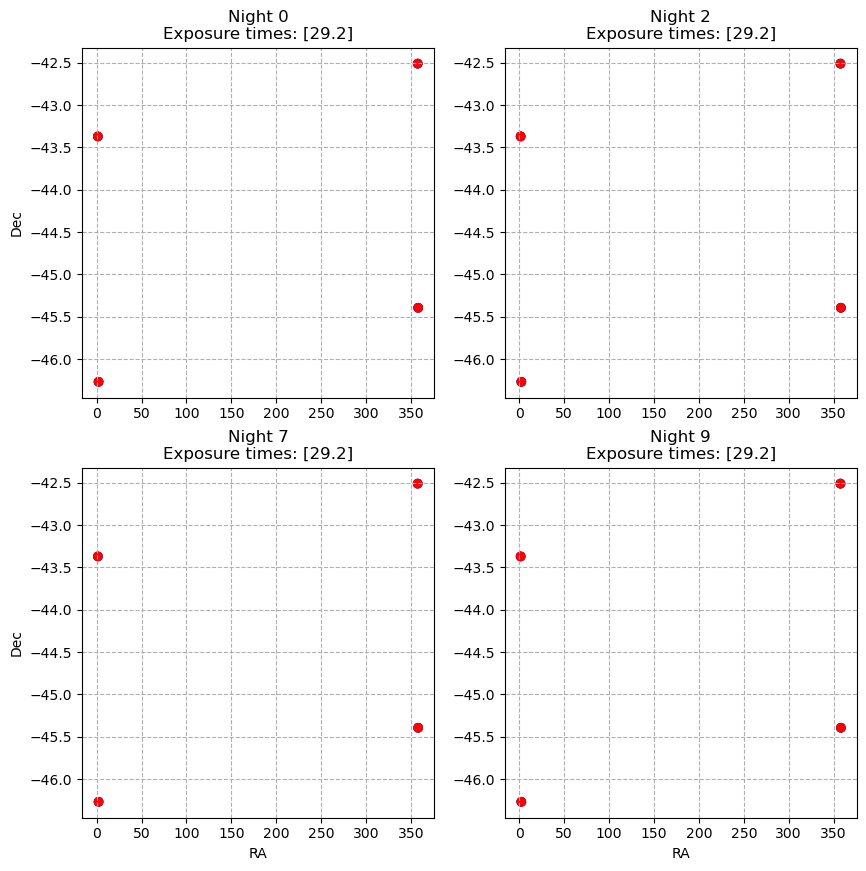

In [23]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
for num,ax in zip(np.unique(ToOObservations[:]["night"]),axs.flatten()):
    strin = "Exposure times: {}".format(np.unique(ToOObservations["exptime"][[t==num for t in ToOObservations[:]["night"]]]))
    subset = ToOObservations[:][[t==num for t in ToOObservations[:]["night"]]]
    ax.scatter(np.rad2deg(subset[:]["RA"]),np.rad2deg(subset[:]["dec"]),color=makeColors(subset[:]["band"]))
    ax.set_title("Night {}\n{}".format(num,strin))
    ax.grid(ls='--')
    # ax.set_xticks(np.arange(0,0.08,step=0.01))
for ax in axs[-1,:]:
    ax.set_xlabel("RA")
for ax in axs[:,0]:
    ax.set_ylabel("Dec")
plt.show()

In [ ]:
362%360